# Inference

In [170]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from moves_encoder import MovesEncoder
import matplotlib.pyplot as plt
from chess import Board
from data_loading import board_to_tensor
from Model import Model
from util import calculate_entropy
import torch
import numpy as np
from IPython.display import display

##### Example board positions

**Open game:** <br> 
rnbqkbnr/pppppppp/8/8/4P3/8/PPPP1PPP/RNBQKBNR b KQkq - 0 1

**King's pawn game:** <br>
rnbqkbnr/pppp1ppp/8/4p3/4P3/8/PPPP1PPP/RNBQKBNR w KQkq - 0 1

**Random endgame puzzle:** <br>
8/5r1p/P5k1/K7/1P6/8/7R/8 b - - 0 1

## Prediction without MCTS

Black to move


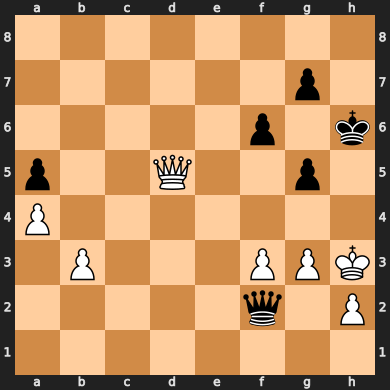

In [171]:
encoder = MovesEncoder()

position_fen = "8/6p1/5p1k/p2Q2p1/P7/1P3PPK/5q1P/8 b - - 1"

board = Board(position_fen)

print("Black to move" if board.turn == 0 else "White to move")
display(board)

In [172]:
# load the model
model = Model(num_actions=encoder.num_actions)
model.load_state_dict(torch.load('model_epoch_12.pth'))
model.eval()

Model(
  (conv1): Conv2d(19, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (conv3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): ReLU()
  (fc1): Linear(in_features=8192, out_features=512, bias=True)
  (fc_relu1): ReLU()
  (fc2): Linear(in_features=512, out_features=4608, bias=True)
)

In [173]:
def predict_move(board: Board):
    X = board_to_tensor(board)

    X = torch.tensor(X, dtype=torch.float32)
    X = X.unsqueeze(0)

    with torch.no_grad():
        output = model(X)
        output = output.squeeze(0)

    probabilities = torch.softmax(output, dim=0).cpu().numpy()

    legal_moves = list(board.legal_moves)
    legal_moves_uci = [move.uci() for move in legal_moves]
    
    # all moves (indices) sorted by probability
    sorted_classes = np.argsort(probabilities)[::-1]

    for move_index in sorted_classes:
        move = encoder.decode(move_index)
        if move in legal_moves_uci:
            return move, probabilities, sorted_classes
    
    return None

def visualize_probabilities(probabilities, sorted_classes, top_n=10):
    top_indices = sorted_classes[:top_n]
    top_probabilities = probabilities[top_indices]
    top_moves = [encoder.decode(i) for i in top_indices]

    plt.figure(figsize=(10, 5))
    plt.title(f"Move probabilities for the top {top_n} moves")
    plt.bar(range(top_n), top_probabilities)
    plt.xticks(range(top_n), top_moves)
    
    plt.text(0.95, 0.95, f'Entropy (for all probabilities): {calculate_entropy(probabilities):.2f}', 
             horizontalalignment='right', 
             verticalalignment='top', 
             transform=plt.gca().transAxes, 
             bbox=dict(facecolor='white', alpha=0.5))
    
    plt.show()

Entropy in bits (for current position): 4.2110424
Max entropy in bits: 12.169925001442312


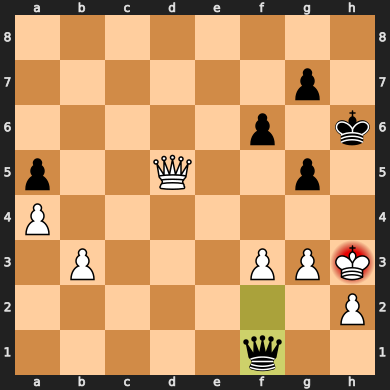

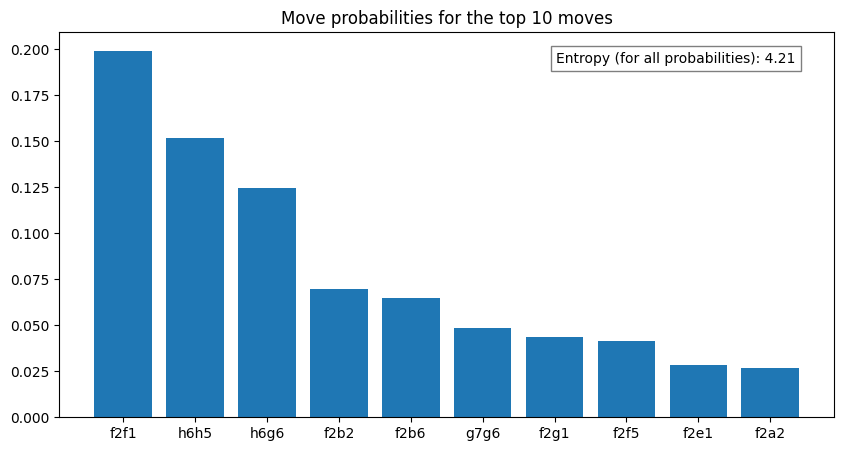

In [174]:
move, probabilities, sorted_classes = predict_move(board)

entropy = calculate_entropy(probabilities)

print('Entropy in bits (for current position):', entropy)
print('Max entropy in bits:', encoder.max_entropy)

board.push_uci(move)

display(board)

visualize_probabilities(probabilities, sorted_classes, 10)